In [2]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout,BatchNormalization,GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from tensorflow.keras.applications import VGG19
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import numpy as np
from keras.optimizers import SGD,Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [3]:
#Divide the data in Train, Validation and Test Datasets
(X_train,y_train),(X_test,y_test)=datasets.cifar10.load_data()

Print the dimensions of the datasets

In [4]:
print((X_train.shape,y_train.shape))
# print((x_val.shape,y_val.shape))
print((X_test.shape,y_test.shape))

((50000, 32, 32, 3), (50000, 1))
((10000, 32, 32, 3), (10000, 1))


In [5]:
y_train = y_train.reshape(-1, )
y_train.shape

(50000,)

Splitting the train data again - we use the val set as test set and previous test set for final predictions

In [6]:
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [7]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000,) (10000,) (10000, 1)


In [8]:
y_test = y_test.reshape(-1,)
y_test.shape

(10000,)

In [9]:
y_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
len(y_classes)

10

In [10]:
# Define data augmentation transformations for both training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
)
    # brightness_range=[0.5, 1.5],  # Adjust brightness
    # channel_shift_range=50.0,?

In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)


In [12]:
from keras.utils import to_categorical

num_classes = 10  # Assuming you have 10 classes in your classification task

# Convert target labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(40000, 10)
(10000, 10)
(10000, 10)


In [13]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 32
)
val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size = 32
)

In [14]:
# Creating a sequential model and adding layers to it

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
# Define callbacks
checkpoint = ModelCheckpoint("/content/Colab_Notebooks/cifar10_model.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.001,
                          patience=10,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [15]:
batch_size = 32
history = model.fit(
    train_generator,
    steps_per_epoch = len(X_train)// batch_size,
    callbacks=[checkpoint, earlystop, reduce_lr],
    validation_data = val_generator,
    validation_steps = len(X_val)//batch_size,
    epochs = 80
    )

Epoch 1/80
1250/1250 [==============================] - ETA: 0s - loss: 1.8203 - accuracy: 0.3704
Epoch 1: val_accuracy improved from -inf to 0.47576, saving model to /content/Colab_Notebooks/cifar10_model.h5
1250/1250 [==============================] - 59s 34ms/step - loss: 1.8203 - accuracy: 0.3704 - val_loss: 1.4632 - val_accuracy: 0.4758 - lr: 0.0010
Epoch 2/80
   1/1250 [..............................] - ETA: 57s - loss: 1.2906 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - ETA: 0s - loss: 1.3670 - accuracy: 0.5102
Epoch 2: val_accuracy improved from 0.47576 to 0.54347, saving model to /content/Colab_Notebooks/cifar10_model.h5
1250/1250 [==============================] - 39s 31ms/step - loss: 1.3670 - accuracy: 0.5102 - val_loss: 1.2881 - val_accuracy: 0.5435 - lr: 0.0010
Epoch 3/80
1249/1250 [============================>.] - ETA: 0s - loss: 1.1949 - accuracy: 0.5755
Epoch 3: val_accuracy did not improve from 0.54347
1250/1250 [==============================] - 40s 32ms/step - loss: 1.1949 - accuracy: 0.5755 - val_loss: 1.4420 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 4/80
1250/1250 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.6147
Epoch 4: val_accuracy improved from 0.54347 to 0.60116, saving model to /content/Colab_Notebooks/cifar10_model.h5
1250/1250 [==============================] - 40s 32ms/step - loss: 1.0926 - accuracy: 0.6147 - val_loss: 1.1739 - val_accuracy: 0.6012 - lr: 0

In [17]:
model.save("/content/drive/MyDrive/Colab Notebooks.h5")

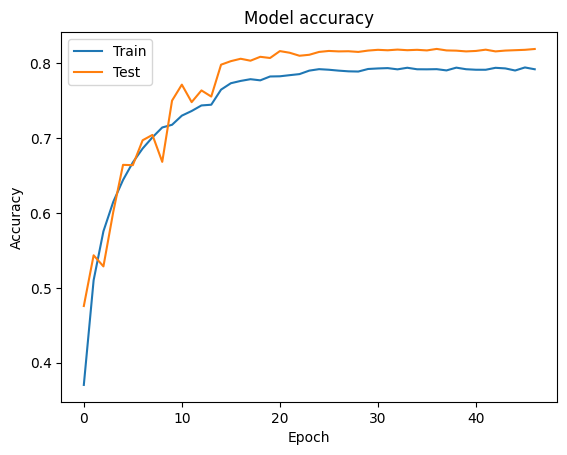

In [18]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

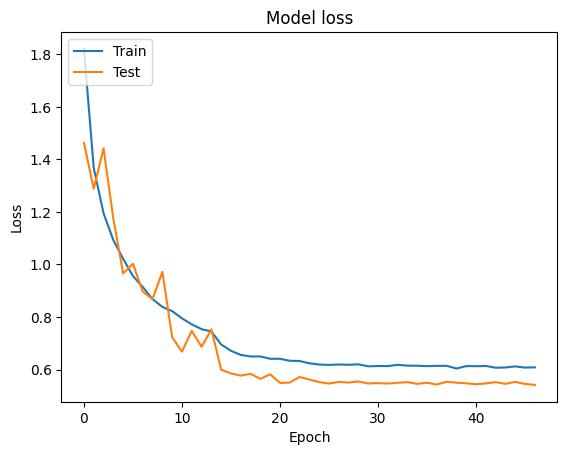

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
## Load and preprocess an image for inference
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

In [22]:
# Load a pre-trained model (e.g., your custom model)
model = load_model("/content/drive/MyDrive/Colab Notebooks.h5")

In [23]:
# Load and preprocess an image
img_path = '/content/horse.jpg'
img = image.load_img(img_path, target_size=(32, 32))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

In [24]:
# Make predictions
predictions = model.predict(x)
class_index = np.argmax(predictions)

1/1 [==============================] - 1s 514ms/step


In [25]:
print(f'Predicted class index: {class_index}')

Predicted class index: 1


1/1 [==============================] - 0s 154ms/step


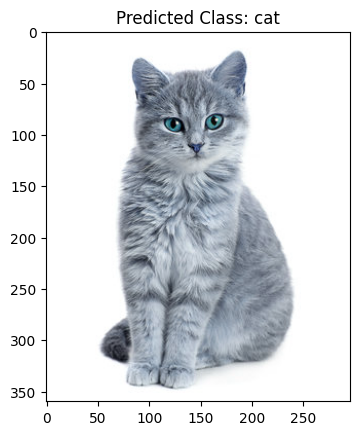

In [31]:
import numpy as np
import cv2
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/Colab Notebooks.h5')

# Read and preprocess the image
test_img = cv2.imread('/content/cats.jpg')
img = cv2.resize(test_img, (32, 32), interpolation=cv2.INTER_CUBIC)
img = np.reshape(img, (1, 32, 32, 3))
img = img / 255.

# Make predictions
pred = model.predict(img)
class_num = np.argmax(pred)
predicted_class = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
predicted_class_name = predicted_class[class_num]

# Display the image and predicted class
plt.imshow(test_img)
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()
